In [271]:
!pip install dash
!pip install dash-html-components
!pip install dash-core-components
!pip install dash-table

In [272]:
!pip install pandas
!pip install numpy

In [273]:
import functools
import operator

from typing import *

import pprint
import collections

import json

In [274]:
import pandas as pd
import numpy as np

In [275]:
# Множество номеров текстов:
IText = Union[int, Iterable[int]]

# Множество номеров терминов:
ITermId = Union[int, Iterable[int]]

# Словарь для предрасчитанных строк из g_deltas. Ключ -- номер текста.
# Если None -- будет использована функция get_delta_row():
IDeltaSource = Optional[Dict[int, np.ndarray]]

# Словарь для набора множеств из множеств номеров терминов.
# См. terms_view(...):
IThesaurusView = Dict[Any, Iterable[int]]

In [276]:
_deltas_df: pd.DataFrame = pd.\
        read_csv('./termwise_prnd_deltas.csv', dtype=np.int32).\
        sort_index().\
        to_numpy()
# g_deltas = _deltas_df[_g_deltas_df]
g_deltas = _deltas_df[:, 1:]
g_deltas_l_index = _deltas_df[:, 0]

def get_delta_rows(
    a_l: IText,
    a_delta_source: IDeltaSource = None
) -> np.ndarray:
    """
    Возвращает словарь numpy-массивов со значениями дельт заданного текста a_l.
    Ключ -- номер текста. Дельта термина номер i лежит на i-й позиции массива.
    
    Если a_delta_source не равно None -- просто возвращает сам a_delta_source.
    """
    
    if isinstance(a_l, int):
        a_l = [a_l]
    elif not isinstance(a_l, collections.abc.Iterable):
        raise ValueError(f'В качестве a_l передано не int и не итерируемое: {a_l}')
    
    if a_delta_source is not None:
        return a_delta_source
    
    return {l: g_deltas[np.searchsorted(g_deltas_l_index, l)] for l in a_l}

In [277]:
import dash
import pandas as pd
from dash import dcc, html, Input, Output, callback

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

def combine_names(row):
    return f"{row['Фамилия']} {row['Имя']} {row['Отчество']}"

g_persons_df = pd.read_csv('./db_persons.csv')[['ID', 'Фамилия', 'Имя', 'Отчество']]
g_persons_df['ФИО'] = g_persons_df.apply(combine_names, axis=1)
gpersons = g_persons_df[['ФИО', 'ID']]
gpersons.columns = ['label', 'value']
gpersons = gpersons.to_dict(orient='records')

app.layout = html.Div([
    html.Label('Выберите автора'),
    dcc.Dropdown(
        options=gpersons,
        placeholder="Выберите автора",
        id='author',
    ),
    html.Div(id='selected-author'),  # Для вывода выбранного значения
    dcc.Dropdown(id='works-dropdown', 
                 multi=True,
                 optionHeight=40),  # Для списка "Работы"
    html.Div(id='selected-pub'),  # Для вывода выбранного значения
], style={'columnCount': 1})

# Глобальная переменная для хранения значения автора
selected_author_value = None

# Функция обратного вызова для обновления выбранного автора
@app.callback(
    Output('selected-author', 'children'),
    Input('author', 'value')
)
def update_selected_author(selected_value):
    global selected_author_value
    selected_author_value = selected_value
    
    if selected_value is None:
        return "Выберите автора"
    else:
        return f"Выбран автор: {selected_value}"



# Глобальная переменная для хранения значения автора
selected_pub_value = []


@app.callback(
    Output('works-dropdown', 'options', allow_duplicate=True),
    Output('works-dropdown', 'value', allow_duplicate=True),
    Output('selected-pub', 'children'),
    Input('works-dropdown', 'value'),
    prevent_initial_call=True
)
def update_selected_pub(selected_value):
    global selected_author_value
    global selected_pub_value

    selected_pub_value = selected_value
    if selected_value is None:
        return [], [], []
    if selected_value.count('Все работы'):
        return [{'label': "Все работы", 'value': 'Все работы'}], ['Все работы'], ['Все работы']
    else:
        all_options = update_works_dropdown(selected_author_value)
        return all_options[0], selected_value, selected_pub_value


# Функция обратного вызова для обновления списка "Работы"
@app.callback(
    Output('works-dropdown', 'options'),
    Output('works-dropdown', 'value'),
    Input('author', 'value'),
)
def update_works_dropdown(selected_value):
    
    if selected_value is None:
        return [], []

    # Загрузка данных из файла "data_from_json_files.csv"
    data_df = pd.read_csv('./data_from_json_files.csv')

    # Преобразование выбранного ID автора в строку
    selected_value_str = str(selected_value)

    # Разделение значения "Авторы" на список ID авторов
    data_df['Авторы'] = data_df['Авторы'].apply(lambda x: [] if pd.isna(x) else x.split(', '))

    # Фильтрация строк, в которых в списке ID авторов есть выбранный автор
    works = data_df[data_df['Авторы'].apply(lambda x: selected_value_str in x)]

    works_data = works[['Название', 'ID']].drop_duplicates(subset=['ID'])
    # Обрезаем названия работ до первых 15 символов
    works_data['Название'] = works_data['Название'].str[:200]
    
    works_data.columns = ['label', 'value']
    works_data = works_data.to_dict(orient='records')
    #print(works_data)
    works_data.insert(0, {'label': "Все работы", 'value': 'Все работы'})
    return works_data, []



if __name__ == '__main__':
    app.run_server(debug=True)


In [286]:
_deltas_df

array([[  853,     0,     0, ...,     0,     0,     0],
       [  911,     0,     0, ...,     0,     0,     0],
       [  927,     0,     0, ...,     0,     0,     0],
       ...,
       [72691,     0,     0, ...,     0,     0,     0],
       [72698,     0,     0, ...,     0,     0,     0],
       [72701,     0,     0, ...,     0,     0,     0]], dtype=int32)

In [342]:
#global selected_pub_value
term_dict_array = []

for i in selected_pub_value:
    for j in _deltas_df:
        if j[0] == i:
            term_dict = {}
            for k in range(1, len(j)):
                if j[k] != 0:
                    term_dict[k-1] = j[k]
            term_dict_array.append(term_dict)

In [343]:
def find_areas_by_term_dicts(data, pub_number, count):
    stack = [((), data)]
    output = []
    while stack:
        path, current = stack.pop()
        if isinstance(current, dict):
            for key, value in current.items():
                if path:
                    new_path = f"{path}.{key}"
                else:
                    new_path = key
                stack.append((new_path, value))
        elif isinstance(current, list):
            for i, item in enumerate(current):
                new_path = f"{path}[{i}]"
                stack.append((new_path, item))
        else:
            if current == pub_number:
                path = path.split(".")
                filtered_array = [item for item in path if 'children' not in item and 'terms' not in item and 'thesaurus' not in item]
                output.append({current: [filtered_array, count]})
    return output

# Входные данные
hierarchy_data = json.load(open('./terms.json', 'r'))
path_array = []
for i in term_dict_array:
    for j in i:
        path_array.append(find_areas_by_term_dicts(hierarchy_data, j, i[j]))

In [346]:
unik_path = {}
for k in path_array:
    for i in k:
        for j in i:
            # print(unik_path[i[j][0][0]], i[j][1])
            if i[j][0][1] in unik_path:
                unik_path[i[j][0][1]] += i[j][1]
            else:
                unik_path[i[j][0][1]] = 0
print(unik_path)

{'Общенаучные термины': 143, 'Теория графов': 0, 'Теория выбора и принятия решений': 1, 'Теория вероятностей и математическая статистика': 0, 'Вычислительные и коммуникационные системы и сети': 0, 'Навигация и управление движением': 0, 'Транспорт': 0, 'Теория оптимизации': 1}


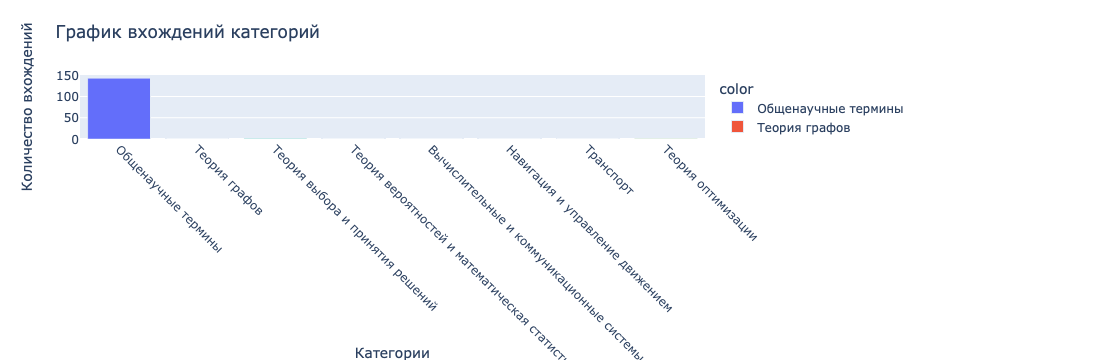

In [347]:
import plotly.express as px

# Создайте список с названиями категорий и соответствующими количествами
categories = list(unik_path.keys())
counts = list(unik_path.values())

# Создайте фигуру с помощью Plotly Express, используя параметр 'color'
fig = px.bar(
    x=categories,
    y=counts,
    labels={'x': 'Категории', 'y': 'Количество вхождений'},
    title='График вхождений категорий',
    color=categories,  # Указываем категории как параметр цвета
    hover_data=[]
)

# Добавьте подписи к столбцам
fig.update_xaxes(tickangle=45)

# Отобразите график
fig.show()


In [21]:
g_ultimate_term_json = json.load(open('./terms.json', 'r'))
g_term_to_words = {int(i): g_ultimate_term_json['term_to_words'][i] for i in g_ultimate_term_json['term_to_words']}
g_term_to_lemmas = {int(i): g_ultimate_term_json['term_to_lemma'][i] for i in g_ultimate_term_json['term_to_lemma']}
g_thesaurus = g_ultimate_term_json['thesaurus']

In [15]:
# Пример использования:
g_thesaurus['children']['Математический аппарат']['children']['Алгебра и теория чисел']['children']['Алгебраическая геометрия']['terms'], g_term_to_words[238], g_term_to_lemmas[238]

([262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272],
 ['представления', 'групп', 'Ли'],
 ['представление', 'группа', 'ли'])

In [16]:
def get_term_words(a_term: int) -> str:
    res = ''
    words = g_term_to_words[a_term]
    for word in words:
        res += word + ' ' 
    return res.strip()

In [17]:
# g_pubs_df = pd.read_csv('./persons/db_pubs.csv').set_index('ID').sort_index()
# g_pubs_df
g_pubs_df = pd.read_csv('./data_from_json_files.csv').\
        set_index('ID').\
        drop('Unnamed: 0', axis=1).\
        sort_index()
# 'Unnamed: 0' -- точно не ID публикации
g_pubs_df = g_pubs_df[~g_pubs_df.index.duplicated(keep='first')]
g_pubs_df

,reference,year,kind,Unnamed: 5,Авторы,Год издания,Название,Наименование источника,DOI,ISBN/ISSN,Город,Наименование конференции,Обозначение и номер тома,"Объём, стр.","Публикация имеет версию на другом языке или вышла в другом издании, например, в электронной (или онлайн) версии журнала",Сведения об издании,Связь с публикацией,Страницы,Электронная публикация
ID,,,,,,,,,,,,,,,,,,,
844,"Корсун В.Ф., Тертышный Г.Г. Методы и средства ...",2005,Доклад,Рассматриваются методы и средства волнового фи...,"10493, 717",2005,Методы и средства волнового фитоуправления в б...,NaN,NaN,NaN,-,Управление и информационные технологии,NaN,NaN,NaN,NaN,NaN,-,NaN
845,"Солонин М.С., Уткин В.А. Метод динамической ко...",2005,Доклад,В докладе рассматривается задача стабилизации ...,"10595, 751",2005,Метод динамической компенсации в задаче оценив...,NaN,NaN,NaN,-,Управление и информационные технологии,NaN,NaN,NaN,NaN,NaN,-,NaN
846,"Краснова С.А., Кузнецов С.И., Уткин А.В. Управ...",2005,Доклад,Рассматривается задача управления угловым поло...,"383, 10594, 750",2005,Управление электромеханическими системами в ус...,NaN,NaN,NaN,-,Управление и информационные технологии,NaN,NaN,NaN,NaN,NaN,-,NaN
847,"Rivera Domínguez J., Лукьянов А.Г., Castillo T...",2005,Доклад,The paper focuses on the design of an error fe...,"10596, 10590, 10597, 751",2005,VSS Error Feedback Regulation for Linear Systems,NaN,NaN,NaN,-,IFAC World Congresses,NaN,NaN,NaN,NaN,NaN,-,NaN
848,"Кузнецов С.И., Сиротина Т.Г., Уткин В.А. Задач...",2005,Тезисы доклада,Предложена декомпозиционная процедура синтеза ...,"10594, 664, 751",2005,Задача стабилизации линейных систем с сигмоида...,NaN,NaN,NaN,-,Системы управления эволюцией организации,NaN,NaN,NaN,NaN,NaN,-,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72933,"Широкий А.А., Калашников А.О. Influence of the...",2023,Статья в журнале/сборнике,This paper is devoted to studying the influenc...,"47161, 9742",2023,Influence of the Internal Structure on the Int...,Mathematics,10.3390/math11040998,2227-7390,"Basel, Switzerland",NaN,"Т. 11, вып. 4",NaN,NaN,NaN,NaN,https://www.mdpi.com/2227-7390/11/4/998,Да
72940,"Воеводин А.В., Корняков А.А., Петров А.С., Пет...",2021,Статья в журнале/сборнике,A problem of the flow around a rectangular win...,"72903, 72906, 72904, 70957, 72905",2021,Wing buffet control by using an ejector-type d...,Journal of Applied Mechanics and Technical Phy...,10.1134/S0021894421020152,0021-8944,Zhukovsky,NaN,"Т. 62, №2",NaN,Да,NaN,"<a href=""/node/72910"">72910</a>",308–316,NaN
72941,"Жарко Е.Ф., Чернышев К.Р. Digital Twins: Forec...",2023,Доклад,"Industries, especially in the energy sector, a...","256, 794",2023,Digital Twins: Forecasting and Formation of Op...,Proceedings of the 2023 International Russian ...,10.1109/SmartIndustryCon57312.2023.10110766,978-1-6654-6429-1,Piscataway,2023 International Russian Smart Industry Conf...,NaN,NaN,NaN,NaN,NaN,"158-163, https://ieeexplore.ieee.org/document/...",Да


[{'label': 'Сравнительный анализ устойчивости различных методов оценивания параметров билинейной авторегрессионной модели', 'value': 71950}]
